In [2]:
#importo e librerie che mi serviranno
import pymongo
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns

URI = "mongodb://127.0.0.1:27017/?readPreference=primary&ssl=false"
client = pymongo.MongoClient(URI)
db = client['movie_dataset']
num_votazioni = 50
num_film = 5

In [3]:
#PRELEVO LE VARIE PRODUZIONI 
df_production = pd.DataFrame(db.production_companies.find({}))
df_production.head()

,_id,name
0,3,Pixar Animation Studios
1,559,TriStar Pictures
2,2550,Teitler Film
3,10201,Interscope Communications
4,6194,Warner Bros.


In [4]:
df_production = df_production.rename(columns= {'_id' : 'production_companies'})

In [5]:
#PRELEVO I VARI FILM
df_film= pd.DataFrame( db.metadata.aggregate([ {'$project': {'_id': 1, 'production_companies': 1,'vote_average':1,'vote_count':1,'budget':1,'original_title':1}
    }]))
df_film

,_id,budget,original_title,production_companies,vote_average,vote_count
0,862,30000000,Toy Story,[3],7.7,5415.0
1,8844,65000000,Jumanji,"[559, 2550, 10201]",6.9,2413.0
2,15602,0,Grumpier Old Men,"[6194, 19464]",6.5,92.0
3,31357,16000000,Waiting to Exhale,[306],6.1,34.0
4,11862,0,Father of the Bride Part II,"[5842, 9195]",5.7,173.0
...,...,...,...,...,...,...
45428,439050,0,رگ خواب,None,4.0,1.0
45429,111109,0,Siglo ng Pagluluwal,[19653],9.0,3.0
45430,67758,0,Betrayal,[6165],3.8,6.0
45431,227506,0,Satana likuyushchiy,[88753],0.0,0.0


In [6]:
#CONVERTO BUDGET IN INTERO
df_film.budget = df_film.budget.astype(str).astype(int)

In [7]:
#CONVERTO _ID IN INTERO
df_film._id = df_film._id.astype(str).astype(int)

In [8]:
#utilizzo funzione explode, per creare nuove righe dagli elementi dell' array presenti nella colonna genres
df_film = df_film.explode('production_companies')



In [9]:
#FILTRO, PRELEVANDO SOLO I FILM CHE HANNO AVUTO UN CERTO NUMERO DI VOTI
df_film = df_film.mask(df_film.eq('None')).dropna()
df_film = df_film.loc[df_film['vote_count'] >= num_votazioni]    

C:\Users\monob\anaconda3\envs\py37\lib\site-packages\pandas\core\computation\expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\Users\monob\anaconda3\envs\py37\lib\site-packages\pandas\core\computation\expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


In [10]:
#CONTROLLO CHE NON CI SIANO NULL 
df_film.isna().sum()

_id                     0
budget                  0
original_title          0
production_companies    0
vote_average            0
vote_count              0
dtype: int64

In [11]:
(df_film.production_companies=="None").value_counts()

False    25940
Name: production_companies, dtype: int64

In [12]:
#ELIMINO LE RIGHE CHE HANNO BUDGET 0
index_target = df_film[ df_film.budget == 0 ].index

In [13]:
 df_film.drop(index_target , inplace=True)

In [14]:
df_film

,_id,budget,original_title,production_companies,vote_average,vote_count
0,862,30000000,Toy Story,3,7.7,5415.0
1,8844,65000000,Jumanji,559,6.9,2413.0
1,8844,65000000,Jumanji,2550,6.9,2413.0
1,8844,65000000,Jumanji,10201,6.9,2413.0
5,949,60000000,Heat,508,7.7,1886.0
...,...,...,...,...,...,...
45174,407448,34000000,Detroit,8411,7.3,67.0
45174,407448,34000000,Detroit,13184,7.3,67.0
45174,407448,34000000,Detroit,20344,7.3,67.0
45235,277839,5402000,Pattaya,57294,5.3,153.0


In [15]:
#FACCIO JOIN CON IL DATAFRAME CONTENENTE LE PRODUZIONI
df_H1 = pd.merge(df_film, df_production, on='production_companies')

df_H1


,_id,budget,original_title,production_companies,vote_average,vote_count,name
0,862,30000000,Toy Story,3,7.7,5415.0,Pixar Animation Studios
1,9487,120000000,A Bug's Life,3,6.8,2379.0,Pixar Animation Studios
2,863,90000000,Toy Story 2,3,7.3,3914.0,Pixar Animation Studios
3,585,115000000,"Monsters, Inc.",3,7.5,6150.0,Pixar Animation Studios
4,12,94000000,Finding Nemo,3,7.6,6292.0,Pixar Animation Studios
...,...,...,...,...,...,...,...
17019,452068,4000000,Drone,92103,5.7,55.0,Daylight Media
17020,341013,30000000,Atomic Blonde,87733,6.1,748.0,Closed on Mondays Entertainment
17021,374720,100000000,Dunkirk,67254,7.5,2712.0,Kaap Holland Film
17022,395834,11000000,Wind River,27497,7.4,181.0,Star Thrower Entertainment


In [16]:
#produzioni che hanno fatto più film
target = df_H1.groupby('production_companies').count()
target.reset_index(inplace=True)
target =  target.rename(columns = {'name' : 'count'})
target = target.loc[target['count'] >= 250]
target = target.drop(['_id','budget','original_title','vote_average','vote_count'], axis=1)
target

,production_companies,count
3,4,340
23,33,385
177,306,284
1762,6194,412


In [17]:
df_H = pd.merge(df_H1, target, on='production_companies')
df_H.loc[df_H['vote_average'] < 7.5, 'label'] = 0
df_H.loc[df_H['vote_average'] >= 7.5, 'label'] = 1


In [18]:
df_H.label =  df_H.label.astype(int)

In [19]:
data=df_H[df_H['production_companies'] == 33]
data=data[['budget','vote_average','name','label']]
data

,budget,vote_average,name,label
752,35000000,5.5,Universal Pictures,0
753,52000000,7.8,Universal Pictures,1
754,29500000,7.4,Universal Pictures,0
755,30000000,6.0,Universal Pictures,0
756,12000000,6.5,Universal Pictures,0
...,...,...,...,...
1132,75000000,6.8,Universal Pictures,0
1133,22000000,6.6,Universal Pictures,0
1134,55000000,6.0,Universal Pictures,0
1135,125000000,5.4,Universal Pictures,0


In [20]:
#METTENDO LA SOGLIA DI UN BUDGET ALTO A PIù DI 100M VEDIAMO CHE PER LA UNIVERSAL PICTURES ABBIAMO CHE 
#la possibilità di produrre UN FILM BELLO AVENDO A DISPOSIZIONE UN BUDGET MINORE è maggiore
test_low =  data.loc[data['budget'] < 100000000	 ]
t_low = test_low.loc[test_low['label']==1]
test_high =  data.loc[data['budget'] >= 100000000	 ]
t_high = test_high.loc[test_high['label']== 1]


In [21]:
#PERCENTUALE DI TROVARE UN FILM CON VALUTAZIONE ALTA AVENDO UN BUDGET  BASSO
low_budget = (t_low.shape[0]/test_low.shape[0])*100
low_budget

7.670454545454546

In [22]:
#PERCENTUALE DI TROVARE UN FILM CON VALUTAZIONE ALTA AVENDO UN BUDGET  ALTO
high_budget = (t_high.shape[0]/test_high.shape[0])*100
high_budget

3.0303030303030303

Text(0.5, 1.0, 'Universal Pictures')

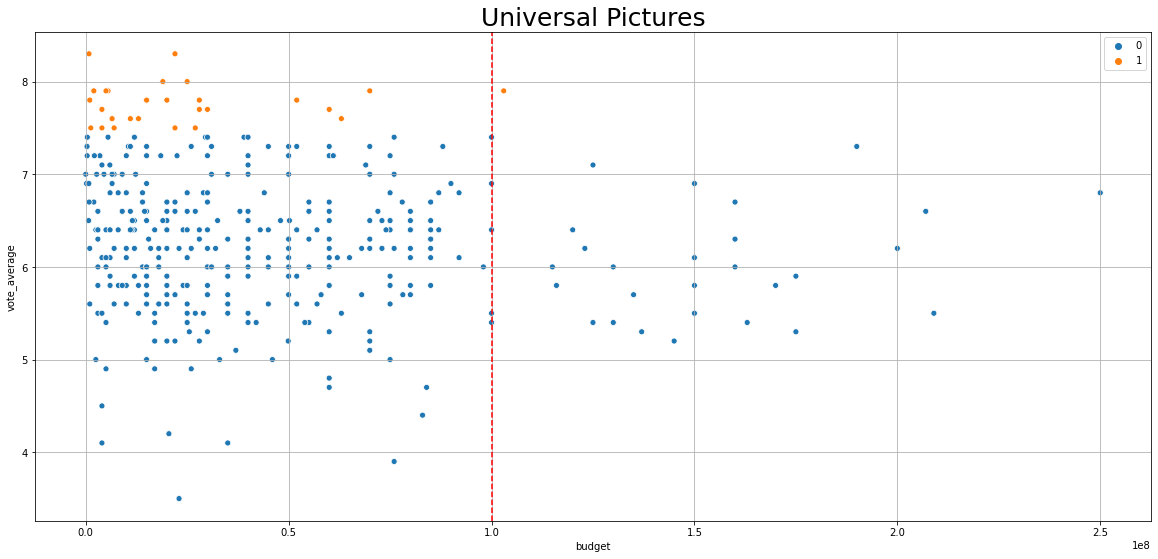

In [40]:
plt.figure(figsize=(20,9))
plt.grid()
sns.scatterplot(data=data, x="budget", y="vote_average", hue= data.label.tolist())
plt.axvline(x=100000000, color='red',linestyle='--')
plt.title('Universal Pictures',fontsize=25)

In [24]:
data1=df_H[df_H['production_companies'] == 6194]
data1=data1[['budget','vote_average','name', 'label']]
data1

,budget,vote_average,name,label
0,60000000,7.7,Warner Bros.,1
1,30000000,6.1,Warner Bros.,0
2,50000000,6.0,Warner Bros.,0
3,50000000,4.1,Warner Bros.,0
4,24000000,7.3,Warner Bros.,0
...,...,...,...,...
407,185000000,6.2,Warner Bros.,0
408,175000000,6.5,Warner Bros.,0
409,25000000,6.2,Warner Bros.,0
410,25000000,6.6,Warner Bros.,0


In [25]:
#METTENDO LA SOGLIA DI UN BUDGET ALTO A PIù DI 100M VEDIAMO CHE PER LA WARNER BROS ABBIAMO CHE 
#LA POSSIBILTà DI PRODURRE UN BEL FILM è ALTA CON QUALSIASI BUDGET
test1_low =  data1.loc[data1['budget'] < 100000000	 ]
t1_low = test1_low.loc[test1_low['label']==1]
test1_high =  data1.loc[data1['budget'] >= 100000000	 ]
t1_high = test1_high.loc[test1_high['label']== 1]


In [26]:
#PERCENTUALE DI TROVARE UN FILM CON VALUTAZIONE ALTA AVENDO UN BUDGET  BASSO
low1_budget = (t1_low.shape[0]/test1_low.shape[0])*100
low1_budget

13.78299120234604

In [27]:
#PERCENTUALE DI TROVARE UN FILM CON VALUTAZIONE ALTA AVENDO UN BUDGET  ALTO
high1_budget = (t1_high.shape[0]/test1_high.shape[0])*100
high1_budget

16.901408450704224

Text(0.5, 1.0, 'Warner Bros')

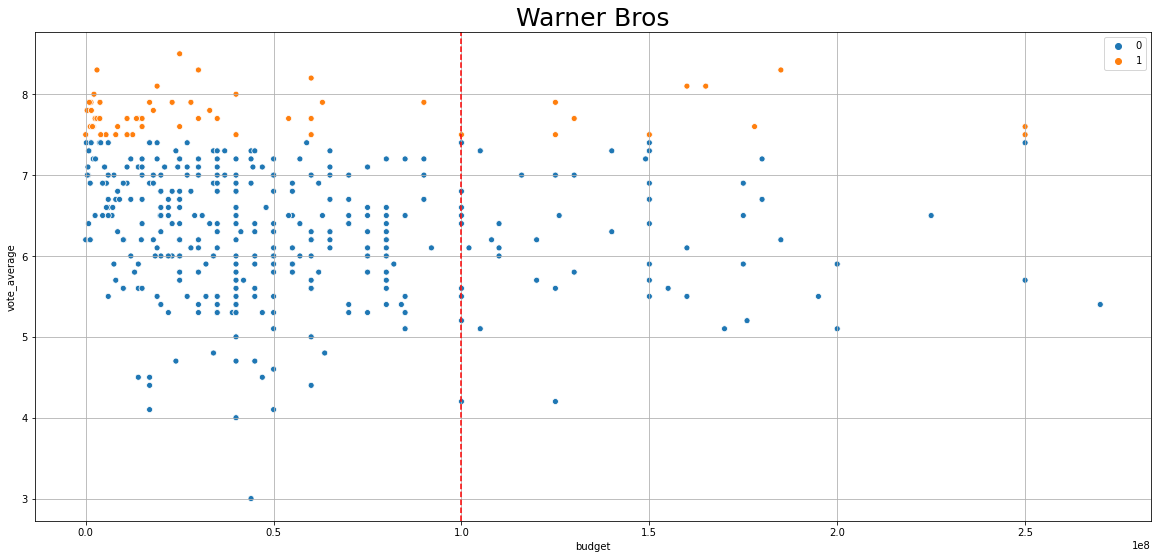

In [41]:
plt.figure(figsize=(20,9))
plt.grid()
sns.scatterplot(data=data1, x="budget", y="vote_average", hue= data1.label.tolist())
plt.axvline(x=100000000, color='red',linestyle='--')
plt.title('Warner Bros',fontsize=25)

In [29]:
data2=df_H[df_H['production_companies'] == 4]
data2=data2[['budget','vote_average','name', 'label']]
data2

,budget,vote_average,name,label
412,58000000,6.2,Paramount Pictures,0
413,12000000,6.9,Paramount Pictures,0
414,45000000,5.9,Paramount Pictures,0
415,20000000,5.8,Paramount Pictures,0
416,8169363,6.1,Paramount Pictures,0
...,...,...,...,...
747,85000000,5.5,Paramount Pictures,0
748,25000000,4.8,Paramount Pictures,0
749,110000000,5.9,Paramount Pictures,0
750,69000000,6.1,Paramount Pictures,0


In [30]:
#METTENDO LA SOGLIA DI UN BUDGET ALTO A PIù DI 100M VEDIAMO CHE PER LA PARAMOUNT PICTURES ABBIAMO CHE 
#la possibilità di produrre UN FILM BELLO AVENDO A DISPOSIZIONE UN BUDGET MINORE è maggiore
test2_low =  data2.loc[data2['budget'] < 100000000	 ]
t2_low = test2_low.loc[test2_low['label']==1]
test2_high =  data2.loc[data2['budget'] >= 100000000	 ]
t2_high = test2_high.loc[test2_high['label']== 1]


In [31]:
#PERCENTUALE DI TROVARE UN FILM CON VALUTAZIONE ALTA AVENDO UN BUDGET  BASSO
low2_budget = (t2_low.shape[0]/test2_low.shape[0])*100
low2_budget

10.774410774410773

In [32]:
#PERCENTUALE DI TROVARE UN FILM CON VALUTAZIONE ALTA AVENDO UN BUDGET  ALTO
high2_budget = (t2_high.shape[0]/test2_high.shape[0])*100
high2_budget

6.976744186046512

Text(0.5, 1.0, 'Paramount Pictures')

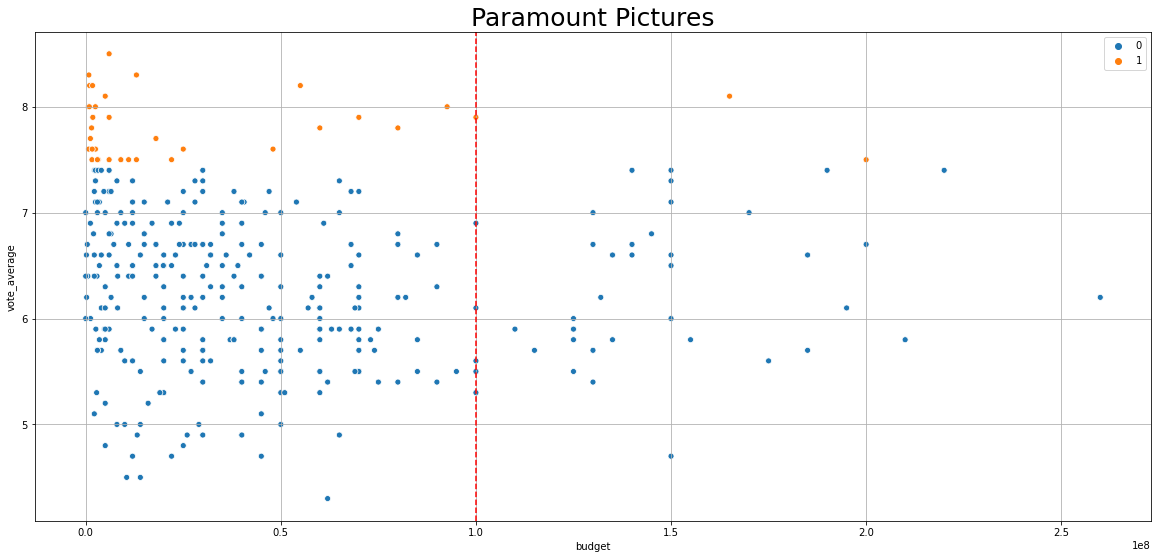

In [43]:
fig = plt.figure(figsize=(20,9))
plt.grid()
sns.scatterplot(data=data2, x="budget", y="vote_average", hue= data2.label.tolist())
plt.axvline(x=100000000, color='red',linestyle='--')
plt.title('Paramount Pictures',fontsize=25)


In [34]:
#LA WARNER BROS è LA COMPAGNIA DI PRODUZIONE APPARENTEMENTE MIGLIORE, POICHè GARSNTISCE FILM DI QUALITà SIA AD ALTO CHE BASSO BUDGET SPESO